# Tutorial Step 2: What's in a GWOSC Data File?

In this tutorial, we will use python to read the file downloaded in [Step 1](<./01 - Download GWOSC Data.ipynb>).
This step presents some details about the file format use in GWOSC data files.
[Step 5](<./05 - GWpy examples.pynb>) will present a higher-level API to read those files.

<div class="alert alert-block alert-warning">
<div><b> &#9888 Warning</b></div>
    Uncomment the following cell if running in Google Colab.
    If you use other running methods, it should not be necessary.
</div>

In [1]:
#! wget http://gwosc.org/archive/data/O3b_4KHZ_R1/1263534080/H-H1_GWOSC_O3b_4KHZ_R1-1264312320-4096.hdf5

## The GWOSC HDF5 file format

The data file uses the standard [HDF5 file format](https://www.hdfgroup.org/solutions/hdf5).
This format is used to store large amounts of scientific data and their meta-data (called attributes) in a hierarchical structure and process them efficiently.
It is a common format in the scientific world and there are many tools and libraries to work with such files.

A first option to view the structure of an HDF5 file is the [HDFView tool](https://www.hdfgroup.org/downloads/hdfview/), a free software which can be downloaded from the HDF Group web site.
This will give you an interactive display of the content inside GWOSC data file.

## Programmatic access with python

### A first glimpse

[h5py](http://www.h5py.org/) is a python package to work with HDF5 files.
With it, you can access the content using a dictionary interface.

In [2]:
#----------------------
# Import needed modules
#----------------------
import numpy as np
import matplotlib.pylab as plt
import h5py

In [3]:
#--------------
# Open the File
#--------------
filename = 'H-H1_GWOSC_O3b_4KHZ_R1-1264312320-4096.hdf5'
dataFile = h5py.File(filename, 'r')

In [4]:
#-----------------
# Explore the file
#-----------------
for key in dataFile.keys():
    print(key)

meta
quality
strain


You can now access the data as in a dictionary.

### Plot a time series

Let's continue our exploration to make a plot of a few seconds of data. To store the strain data in a convenient place, use the code below:

In [5]:
#--------------------
# Read in strain data
#--------------------
strain = dataFile['strain']['Strain']
ts = dataFile['strain']['Strain'].attrs['Xspacing']
print(f"ts = {ts}s, sample rate = {1/ts}Hz")

ts = 0.000244140625s, sample rate = 4096.0Hz


The code above accesses the `'Strain'` data object that lives inside the group `'strain'` - we store this as `strain`.
The "attribute" `'Xspacing'` tells how much time there is between each sample, and we store this as `ts`.
To see all the structure of a GWOSC data file, see the end of this tutorial.

Now, let's use the meta-data to make a vector that will label the time stamp of each sample. In the same way that we indexed `dataFile` as a python dictionary, we can also index `dataFile['meta']`. To see what meta-data we have to work with, use the code below:

In [6]:
#-------------------------
# Print out some meta data
#-------------------------
metaKeys = dataFile['meta'].keys()
meta = dataFile['meta']
for key in metaKeys:
    print(key, meta[key])

Description <HDF5 dataset "Description": shape (), type "|O">
DescriptionURL <HDF5 dataset "DescriptionURL": shape (), type "|O">
Detector <HDF5 dataset "Detector": shape (), type "|O">
Duration <HDF5 dataset "Duration": shape (), type "<i8">
FrameType <HDF5 dataset "FrameType": shape (), type "|O">
GPSstart <HDF5 dataset "GPSstart": shape (), type "<i8">
Observatory <HDF5 dataset "Observatory": shape (), type "|O">
StrainChannel <HDF5 dataset "StrainChannel": shape (), type "|O">
Type <HDF5 dataset "Type": shape (), type "|O">
UTCstart <HDF5 dataset "UTCstart": shape (), type "|O">


You should see that the GPS start time and the duration are both stored as meta-data.
To calculate how much time passes between samples, we can divide the total duration by the number of samples:

In [7]:
#---------------------
# Create a time vector
#---------------------
gpsStart = meta['GPSstart'][()]
duration = meta['Duration'][()]
gpsEnd   = gpsStart + duration

time = np.arange(gpsStart, gpsEnd, ts)

The numpy command `arange` creates an array (think a column of numbers) that starts at `gpsStart`, ends at `gpsEnd` (non-inclusive), and has an increment of `ts` between each element.

We can now plot the data:

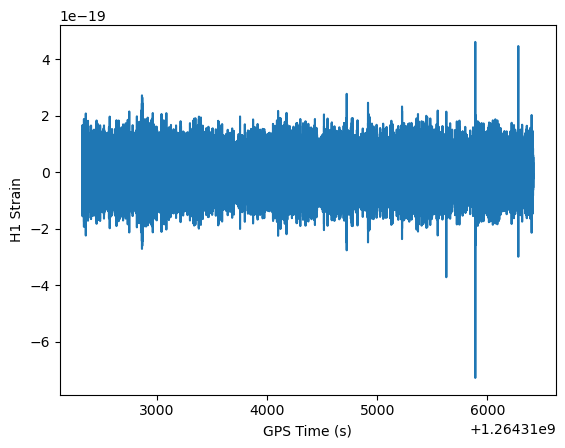

In [8]:
#---------------------
# Plot the time series
#---------------------
plt.plot(time, strain[()])
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()

Finally, let's use all of this to plot a few seconds worth of data.
Since this data is sampled at 4096 Hz, 10,000 samples corresponds to about 2.4 s.
We will start at time 1256779566.0.

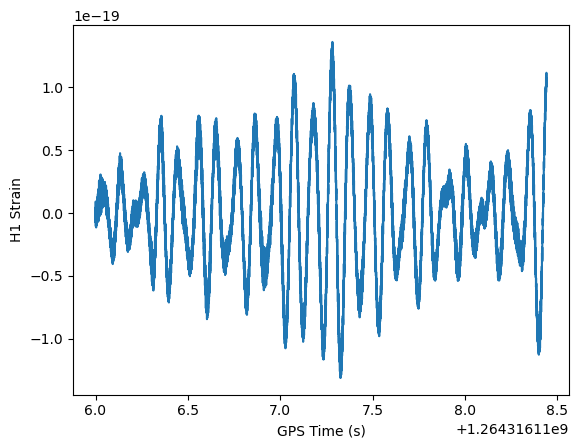

In [9]:
#------------------------
# Zoom in the time series
#------------------------
numsamples = 10000
startTime  = 1264316116.0
startIndex = np.min(np.nonzero(startTime < time))
time_seg   = time[startIndex:(startIndex+numsamples)]
strain_seg = strain[startIndex:(startIndex+numsamples)]
plt.plot(time_seg, strain_seg)
plt.xlabel('GPS Time (s)')
plt.ylabel('H1 Strain')
plt.show()

You may be surprised that the data looks smooth and curvy, rather than jagged and jumpy as you might expect for [white noise](https://en.wikipedia.org/wiki/White_noise).
That's because white noise has roughly equal power at all frequencies, which GW data does not.
Rather, GW data includes noise that is a strong function of frequency - we often say the noise is "colored" to distinguish it from white noise.
The wiggles you see in the plot above are at the low end of the LVK band (around 20 Hz).
In general, GW noise is dominated by these low frequencies.
To learn more about GW noise as a function of frequency, take a look at the [Step 4 of this tutorial](<04 - Working in Frequency Domain.ipynb>). 

### A slightly more advanced script

Let's write a short python script for viewing the _entire_ structure of a GWOSC data file.
It is based on the [visititems](https://docs.h5py.org/en/stable/high/group.html#h5py.Group.visititems) method.

In [10]:
def dump_info(name, obj):
    print("{0} :".format(name))
    try:
        print("   value: {0}".format(str(obj[()])))
        for key in obj.attrs.keys():
            print("     attrs[{0}]:  {1}".format(key, obj.attrs[key]))
    except:
        pass

file = h5py.File(filename)
file.visititems(dump_info)

meta :
meta/Description :
   value: b'Strain data time series from LIGO'
meta/DescriptionURL :
   value: b'http://www.gw-openscience.org/'
meta/Detector :
   value: b'H1'
meta/Duration :
   value: 4096
meta/FrameType :
   value: b'H1_HOFT_CLEAN_SUB60HZ_C01'
meta/GPSstart :
   value: 1264312320
meta/Observatory :
   value: b'H'
meta/StrainChannel :
   value: b'H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01'
meta/Type :
   value: b'StrainTimeSeries'
meta/UTCstart :
   value: b'2020-01-29T05:51:42'
quality :
quality/detail :
quality/injections :
quality/injections/GWOSCmeta :
   value: b'GWOSC-4KHZ_R1_INJMASK'
quality/injections/InjDescriptions :
   value: [b'no cbc injection' b'no burst injections' b'no detchar injections'
 b'no continuous wave injections' b'no stoch injections']
quality/injections/InjShortnames :
   value: [b'NO_CBC_HW_INJ' b'NO_BURST_HW_INJ' b'NO_DETCHAR_HW_INJ' b'NO_CW_HW_INJ'
 b'NO_STOCH_HW_INJ']
quality/injections/Injmask :
   value: [23 23 23 ... 23 23 23]
     attrs[Bits]:

## What's next?

In the [next step](<03 - Working with Data Quality.ipynb>), you will learn how to work with data quality.